In [17]:
import pywt
import matplotlib.pyplot as plt
import numpy as np
import librosa
from scipy.fftpack import dct, idct
import glob
import os
import subprocess
from random import sample

SAMPLE_RATE = 24000
WAVELET_NAME = "mexh"
WAVELET_SCALES = np.arange(0.5, 32, 1)
EXAMPLES_PER_BATCH = 32
SAMPLES_PER_EXAMPLE = SAMPLE_RATE * 4
NUM_WAVES = 3
NUM_OTHER_FEATURES = 11
NUM_MELS = 32
NUM_DCT_COEFFICIENTS = 10
SYNTHESIZER_PATH = "C:\\Users\\abdulg\\source\\repos\\Synth\\out\\build\\x64-debug\\synth.exe"

PARAMETER_LBS = np.asarray([0, 0, 0, 440, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0])
PARAMETER_RANGE = np.asarray([1, 1, 1, 1661.22, 1661.22, 1, 1, 1, 1, 1, 8, 1/2, 8, 1/32]) - PARAMETER_LBS

In [ ]:
#populate validation set
datapath = os.path.abspath("./validationdata")
subprocess.run(f"{SYNTHESIZER_PATH} 600 {datapath}", stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [ ]:
#finding scale range
pywt.frequency2scale(WAVELET_NAME, SAMPLE_RATE // 2) * SAMPLE_RATE

In [ ]:
#finding biggest scale
bins = np.linspace(0, SAMPLE_RATE/2, 100)
hist = np.zeros(100 - 1)
freqs = np.fft.fftfreq(SAMPLES_PER_EXAMPLE, d=1/SAMPLE_RATE)

waves = [librosa.load(waveFile, sr=SAMPLE_RATE, dtype=np.float32)[0] for waveFile in glob.glob(os.path.join(datapath, "*.wav"))]

for wave in waves:
	result = np.abs(np.fft.fft(wave))
	hist += np.histogram(freqs, bins=bins, weights=result)[0]

hist /= len(waveFiles)

# Plot the energy content histogram
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], hist, width=bins[1] - bins[0])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Energy')
plt.show()

In [ ]:
#show a scaleogram
import pywt
import librosa
import numpy as np
import matplotlib.pyplot as plt

SAMPLE_RATE = 24000
WAVELET_NAME = "mexh"
WAVELET_SCALES = np.arange(0.5, 32, 1)
signal, _ = librosa.load("C:\\Users\\abdulg\\Desktop\\waves\\string.wav", sr = SAMPLE_RATE)
coeffs, _ = pywt.cwt(signal, WAVELET_SCALES, WAVELET_NAME)
plt.specgram(signal, cmap="magma")
plt.axis("off")
plt.show()

In [ ]:
[psi, x] = pywt.ContinuousWavelet("mexh").wavefun()
cosSamples = np.cos()
plt.plot(x, psi)
plt.axis("off")
plt.show()

In [ ]:
#fft plotting code
spectrum = np.fft.fft(signal)
print(len(spectrum))
frequencies = np.fft.fftfreq(len(signal), d=1/16000)

plt.plot(frequencies[:len(frequencies)//10], np.abs(spectrum)[:len(frequencies)//10])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.show()

In [ ]:
#too big!
print(np.shape(coeffs))
#try downsampling, but we introduce 'ripples' in the image that could confuse the CNN for an LFO
coeffs2 = block_reduce(coeffs, (2,32), np.max)
print(np.shape(coeffs2))
plt.imshow(np.abs(coeffs2), extent=[0, len(signal), 1, 80], cmap="viridis", aspect="auto", origin="lower")
plt.axis("off")
plt.show()

In [ ]:
import pickle
with open("./lastHistory", "rb") as histFile:
	history = pickle.load(histFile)
	plt.plot(history["loss"])
	plt.plot(history["val_loss"])
	plt.title("model loss")
	plt.ylabel("loss")
	plt.xlabel("epoch")
	plt.legend(["train", "val"], loc="upper left")
	plt.show()

In [ ]:
#dct coefficient magnitudes
def normaliseParams(params):
	return (params - PARAMETER_LBS)/PARAMETER_RANGE

def processWavs(datapath):
	waveFiles = sample(sorted(glob.glob(os.path.join(datapath, "*.wav"))), 1)
	waves = [librosa.load(waveFile, sr=SAMPLE_RATE, dtype=np.float32)[0] for waveFile in waveFiles]
	scaleograms = [pywt.cwt(wave, WAVELET_SCALES, WAVELET_NAME)[0] for wave in waves]

	return (
		np.asarray([dct(scaleo, type=2, axis=1)[:, :NUM_DCT_COEFFICIENTS] for scaleo in scaleograms])
	)

def getValidationSet():
	print("generating validation data")
	datapath = os.path.abspath("./validationdata")
	subprocess.run(f"{SYNTHESIZER_PATH} 600 {datapath}", stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
	return processWavs(datapath)

def superImpose(heights):
	#colors = [np.random.choice(range(256), size=3) for _ in range(len(heights))]
	canvases = [np.zeros((len(heights), max(heights))) for _ in range(len(heights))]
	for i in range(heights):
		for h in heights:
			canvases[i][:h] = 1
	return np.transpose(np.mean(canvases, axis=1))


#energy
arrs = getValidationSet()
indices = np.arange((arrs[0].shape)[-1])

for arr in arrs:
    plt.bar(indices, np.sum(np.square(arr), axis=0), alpha=0.3) 

plt.xlabel("Index")
plt.ylabel("Value")

plt.show()

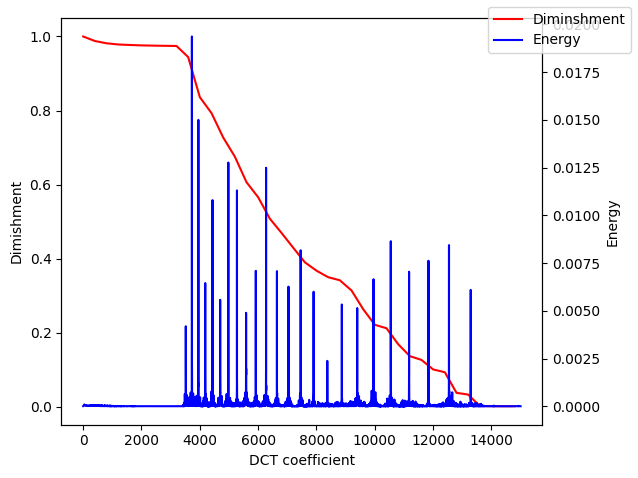

In [49]:
#check energy retention for some number of DCT coefficients
def loadScaleos():
	datapath = os.path.abspath("./validationdata")
	waveFiles = glob.glob(os.path.join(datapath, "*.wav"))
	waves = [librosa.load(waveFile, sr=SAMPLE_RATE, dtype=np.float32)[0] for waveFile in waveFiles]
	wavesWithEnergy = [w for w in waves if np.max(w) > 0]
	return np.asarray([pywt.cwt(wave, WAVELET_SCALES, WAVELET_NAME)[0] for wave in wavesWithEnergy])

def invertDCT(scaleo):
	return idct(scaleo, type=2, axis=1, norm="ortho")

def getAverageEnergyDiminishment(numCoeffs):
	truncDCTs = dcts[:, :, :numCoeffs]
	originalLength = len(scaleos[0][0])
	rehydratedScaleos = np.asarray([invertDCT(truncScaleo) for truncScaleo in truncDCTs])
	rehydratedEnergies = np.asarray([np.sum(rehydratedScaleo ** 2) for rehydratedScaleo in rehydratedScaleos])
	return np.mean(1 - rehydratedEnergies / scaleoEnergies)

scaleos = loadScaleos()
scaleoEnergies = np.asarray([getScaleoEnergy(scaleo) for scaleo in scaleos])
dcts = np.asarray([dct(scaleo, type=2, axis=1, norm="ortho") for scaleo in scaleos])

candidates = range(1, 15000, 400)
diminishment = [getAverageEnergyDiminishment(c) for c in candidates]

energiesPerCoefficientPerExample = np.sum(np.asarray(dcts) ** 2, axis=1)
energies = np.sum(energiesPerCoefficientPerExample, axis=1)
meanNormalisedEPCPE = np.mean(energiesPerCoefficientPerExample / energies[:, np.newaxis], axis=0)

fig, ax1 = plt.subplots()

ax1.set_xlabel("DCT coefficient")
ax1.set_ylabel("Dimishment")
ax1.plot(candidates, diminishment, color="red", label="Diminshment")

ax2 = ax1.twinx()

ax2.set_ylabel("Energy")
ax2.plot(range(15000), meanNormalisedEPCPE[:15000], color="blue", label="Energy")
fig.legend(loc="upper right")
fig.tight_layout()

plt.show()

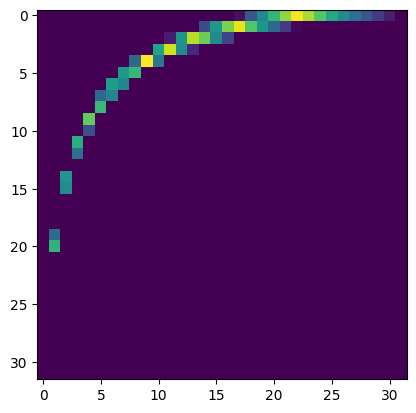

In [4]:
#'wavelet mel-filterbank'
NUM_MELS = 32
freqs = [pywt.scale2frequency(WAVELET_NAME, scale) * SAMPLE_RATE for scale in WAVELET_SCALES] 

def freq2Mel(freq):
	return 1125 * np.log(1 + freq / 700)

lowestMel = freq2Mel(freqs[-1])
highestMel = freq2Mel(freqs[0])
mels = np.linspace(lowestMel, highestMel, NUM_MELS + 2)

def mel2Freq(mel):
	return 700 * (np.exp(mel/1125) - 1)

freqPoints = [mel2Freq(mel) for mel in mels]

#get one row, lowest scale should be at the top of the CWT
def melFilter(melNumber):
	row = np.zeros(len(WAVELET_SCALES))
	for i in range(len(WAVELET_SCALES)):
		currentScaleFreq = freqs[i]
		if currentScaleFreq >= freqPoints[melNumber]:
			if currentScaleFreq <= freqPoints[melNumber + 1]:
				row[i] = (currentScaleFreq - freqPoints[melNumber])/(freqPoints[melNumber + 1] - freqPoints[melNumber])
			elif currentScaleFreq <= freqPoints[melNumber + 2]:
				row[i] = (freqPoints[melNumber + 2] - currentScaleFreq )/(freqPoints[melNumber + 2] - freqPoints[melNumber + 1])
	return row

fbank = np.asarray([melFilter(i) for i in range(NUM_MELS)])

plt.imshow(fbank)

In [ ]:
def getScaleograms(waveFiles):
	waves = [librosa.load(waveFile, sr=SAMPLE_RATE, dtype=np.float32)[0] for waveFile in waveFiles]
	return np.asarray([np.abs(pywt.cwt(wave, WAVELET_SCALES, WAVELET_NAME)[0]) for wave in waves])

def getMLSs(waveFiles):
	scaleograms = getScaleograms(waveFiles)
	melScaleograms = [np.matmul(fbank, scaleo)**2 for scaleo in scaleograms]
	return np.asarray(melScaleograms) #[librosa.power_to_db(melScaleo) for melScaleo in melScaleograms])

datapath = os.path.abspath("./validationdata")
randomSample = sample(sorted(glob.glob(os.path.join(datapath, "*.wav"))), 1)
scaleo = getScaleograms(randomSample)[0]
datapath = os.path.abspath("./validationdata")
randomSample = sample(sorted(glob.glob(os.path.join(datapath, "*.wav"))), 1)
scaleo = getScaleograms(randomSample)[0]

fig, axes = plt.subplots(2,3)

axes[0][0].imshow(scaleo, cmap="viridis", aspect="auto", origin="upper")
axes[0][0].set_title("scaleogram")
axes[0][0].axis("off")

logs = librosa.power_to_db(scaleo)
axes[0][1].imshow(logs, cmap="viridis", aspect="auto", origin="upper")
axes[0][1].set_title("log scaleogram")
axes[0][1].axis("off")

axes[0][2].imshow(dct(logs, axis=1, type=2, norm="ortho")[:, :10], cmap="viridis", aspect="auto", origin="upper")
axes[0][2].set_title("DCT log scaleogram")
axes[0][2].axis("off")

energies = np.matmul(fbank,scaleo)**2
axes[1][0].imshow(energies, cmap="viridis", aspect="auto", origin="upper")
axes[1][0].set_title("melscaleogram")
axes[1][0].axis("off")

lms = librosa.power_to_db(np.matmul(fbank,scaleo)**2)
axes[1][1].imshow(lms, cmap="viridis", aspect="auto", origin="upper")
axes[1][1].set_title("log-melscaleogram")
axes[1][1].axis("off")

mfcc = dct(lms, axis=1, norm="ortho")[:,:10]
axes[1][2].imshow(mfcc, cmap="viridis", aspect="auto", origin="upper")
axes[1][2].set_title("MFCCs")
axes[1][2].axis("off")

plt.show()

In [ ]:
fix, ax = plt.subplots(1,3)
datapath = os.path.abspath("./validationdata")
randomSample = sample(sorted(glob.glob(os.path.join(datapath, "*.wav"))), 1)
scaleo = getScaleograms(randomSample)[0]
ax[0].imshow(fbank, origin="upper", aspect="auto")
ax[1].imshow(scaleo, origin="upper", aspect="auto")
ax[2].imshow(np.matmul(fbank, scaleo), origin="upper", aspect="auto")

In [ ]:
datapath = os.path.abspath("./validationdata")
randomSample = sample(sorted(glob.glob(os.path.join(datapath, "*.wav"))), 1)
scaleo = getScaleograms(randomSample)[0]
plt.imshow(scaleo, aspect="auto")

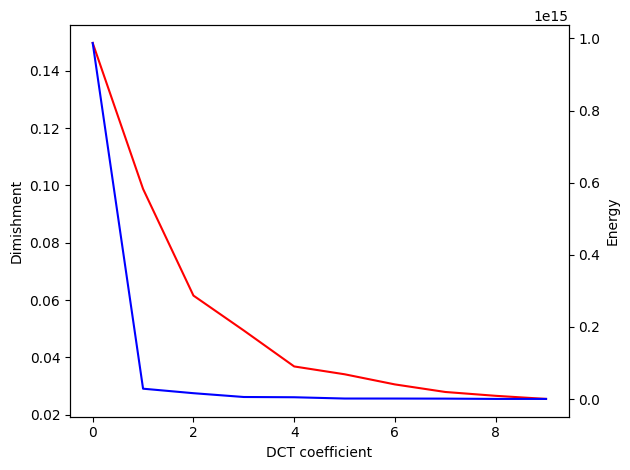

In [24]:
def loadMFCCs():
	datapath = os.path.abspath("./validationdata")
	waveFiles = glob.glob(os.path.join(datapath, "*.wav"))
	waves = [librosa.load(waveFile, sr=SAMPLE_RATE, dtype=np.float32)[0] for waveFile in waveFiles]
	wavesWithEnergy = [w for w in waves if np.max(w) > 0]
	scaleograms = [pywt.cwt(wave, WAVELET_SCALES, WAVELET_NAME)[0] for wave in wavesWithEnergy]
	melScaleograms = [np.abs(np.matmul(fbank, scaleo))**2 for scaleo in scaleograms]
	melLogScaleograms = [librosa.power_to_db(melScaleo) for melScaleo in melScaleograms]
	return np.asarray([dct(scaleo, type=2, axis=1)[:10] for scaleo in melLogScaleograms])

mfccs = loadMFCCs()
energiesPerCoefficient = np.sum(mfccs ** 2, axis=1)
cumulativeEnergyPerCoefficient = np.add.accumulate(energiesPerCoefficient, axis=1)
originalEnergies = np.sum(energiesPerCoefficient, axis=1)

def getAverageEnergyDiminishment(numCoeffs):
	cumulativeEnergies = cumulativeEnergyPerCoefficient[:, numCoeffs]
	return np.mean(1 - cumulativeEnergies / originalEnergies)

candidates = range(10)
diminishment = [getAverageEnergyDiminishment(c) for c in candidates]
averageEPC = np.mean(energiesPerCoefficient, axis=0)[:10]

#energiesPerCoefficientPerExample = np.sum(np.asarray(mfccs) ** 2, axis=1)
#energies = np.sum(energiesPerCoefficientPerExample, axis=1)

#meanNormalisedEPCPE = np.mean(energiesPerCoefficientPerExample, axis=0)

fig, ax1 = plt.subplots()
ax1.set_xlabel("DCT coefficient")
ax1.set_ylabel("Dimishment")
ax1.plot(candidates, diminishment, color="red", label="Diminshment")

ax2 = ax1.twinx()
ax2.set_ylabel("Energy")
ax2.plot(candidates, averageEPC, color="blue", label="Energy")

fig.tight_layout()
plt.show()

51745


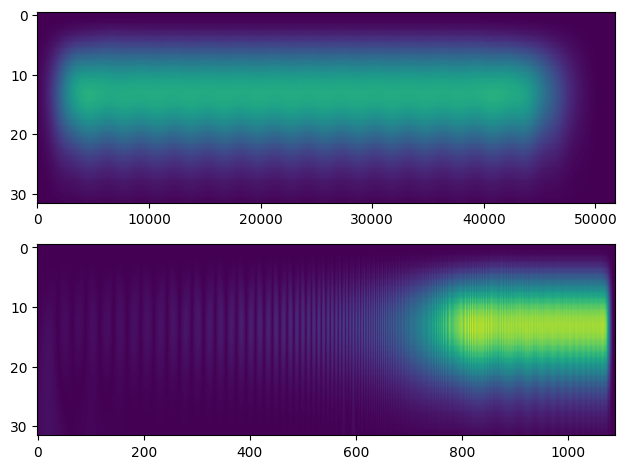

In [25]:
#exponential downsampling
from numpy.lib.scimath import logn

BASE = 1.01
PREFIX = 500
signal, _ = librosa.load("C:\\Users\\abdulg\\Desktop\\waves\\string.wav", sr = SAMPLE_RATE)
coeffs, _ = pywt.cwt(signal[PREFIX:], WAVELET_SCALES, WAVELET_NAME)
coeffs = np.abs(coeffs)

stoppingPoint = 0
for i in range(1, int(logn(BASE, SAMPLES_PER_EXAMPLE - PREFIX)), 1):
	if i + BASE ** i > SAMPLES_PER_EXAMPLE - PREFIX:
		stoppingPoint = i - 1

def logScaleImage(image):
	print(len(image[0]))
	

	indices = [i + int(BASE ** i) for i in range(1, stoppingPoint)]

	splitImages = np.split(image, indices, axis=1)

	return np.asarray([
		[np.mean(frame) for frame in imageFrames] for imageFrames in splitImages
	])

fig, ax = plt.subplots(2)
ax[0].imshow(coeffs, aspect="auto")
ax[1].imshow(logScaleImage(coeffs).T, aspect="auto")
plt.tight_layout()
plt.show()

In [69]:
test = np.asarray([[1,2,3], [4,5,6]])
print(np.sum(test, axis=0))

[5 7 9]


In [ ]:
)